# Multi-Armed Bandit for Data Selection

We follow in the footsteps of Gutiérrez et al (2017). Let us first formulate our objective mathematically.

#### Modelling Objective

We want to model $f: (x, \mathbf{p}) \mapsto y$, where $f$ belongs to the class of linear regression estimators parameterized by vector $\mathbf{p}$. $x_i$  and $y_i$ are the RH98 and AGBD of footprint $i$, respectively. 

Parameters $\mathbf{p}$ are estimated using a training set $S^T = \{ s_1, \ldots, s_{N_{\text{train}}} \}$ consisting of samples $s = (x,y)$. However, $S^T$ is merely a subsample from the available training data $S = \{ h_1, \ldots, h_{N_{\text{total}}} \} $ which consists of _hidden_ samples of the form $h = \{ \tilde{x}, \tilde{y}, \mathbf{m} \}$. They are hidden because RH98 $\tilde{x}$ and AGBD $\tilde{y}$ are only revealed after the sample is added to the training set. By contrast, metadata $\mathbf{m}$ about the sample is known à priori. To begin with, $S$ consists of all data in Ghana with PFT class = 2. 

#### Sample Efficiency Objective

Unlike Gutiérrez et al, we do not incur a large cost from observing $\tilde{x}$ or $\tilde{y}$. However, we are interested in selecting only the most relevant samples according to $\mathbf{m}$ all the same. We will later generalise our method to larger, more complicated datasets and more sophisticated model classes, hence sample efficiency will be important to minimise the computational burden of training the model.

We select samples by partitioning $S$ into a pre-defined number of bins $\eta_j$ for select $m_j$ $(1 \leq j \leq d)$ in $\mathbf{m}$. For instance, if $m_j$ is a categorical variable with four categories, we create the j'th partition $S = \bigcup_{k=1}^{4} C_k^j$, where $C_1^j$ contains all samples where $m_j$ is in class 1, $C_2^j$ contains all samples where $m_j$ is in class 2, etc. If $m_j$ is continuous, we quantize the variable into bins and partition accordingly. All the clusters generated using different meta information are then merged into a set of clusters $\mathcal{C} = \{C_l^j\}$. Our hypothesis is that some clusters $C_i \in \mathcal{C}$ contain more relevant information for the modelling task than others, but we do not know which. This motivates us to train a multi-armed bandit who will simultaneously _explore_ the clusters to find out which contain the most relevant information and eventually _exploit_ these clusters to maximise the share of data therefrom.

The multi-armed bandit algorithm is described in detail in their paper, but to summarise:

* At every time $t$:
    * Sample the probability of reward $\hat{\pi}_i$ from $Beta(\alpha_i, \beta_i)$ for every cluster
    * Pick a datapoint $s$ from the cluster with highest probability of reward
    * Add $s$ to $S^T$ and re-train the model
    * Predict $\hat{y}$ for a holdout validation set
    * If score increases (decreases), $r_t = 1 \ (-1)$
    * Update $\alpha_i, \beta_i$ based on $r_t$ 

#### Summary of Objective

Our dual objectives are then:

1) To optimize the performance of $f$ at predicting $y$, as measured by the MAPE on a holdout test set.
2) To include as few samples as necessary in $S^T$.

We will train a multi-armed bandit data selector to achieve both in parallel.

### Load Packages and Data

In [1]:
import importlib
import pandas as pd
import geopandas as gpd
import pyogrio
import os
import pandas.api.types as ptypes
import numpy as np
import warnings
import pickle as pkl
import types
import statsmodels.api as sm
import folium
import torch
import contextlib
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, PoissonRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score, explained_variance_score, mean_squared_error # , root_mean_squared_error
from matplotlib import pyplot as plt
from scipy.stats import beta
from custom_ttv_split import load_data
from benchmark import benchmark_bandit, benchmark_subset_n, load_specs, lazy_bandit_feature_search

# import robust method to benchmark
from robust_regression import Torrent

# import bandit(s)
from MABS import bandit, crafty_bandit, lazy_bandit, ND_bandit

# import score functions
from custom_score_functions import log_ratio

# import custom models
from custom_models import MLP

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

os.chdir(r"C:\Users\nial\OneDrive\ETH Zürich\Master Thesis")

# PREDICTING AGBD FROM SATELLITE BAND DATA

In [2]:
df_global         = load_data()

Now we try a `lazy_bandit()` with `df_global`

In [3]:
df_global_subset        = df_global.sample(10000, ignore_index=False)

In [4]:
hidden_indices          = df_global_subset[df_global_subset['colour'] == 'train'].index.tolist()
test_indices            = df_global_subset[df_global_subset['colour'] == 'test'].index.tolist()
val_indices             = df_global_subset[df_global_subset['colour'] == 'val'].index.tolist()


x                       = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12"]
y                       = 'agbd'
features                = {'pft_class':None, 'sensitivit':3, 'region_cla':None}
T                       = 1000
batch_size              = 10
test_freq               = 10

n_predictors            = len(x)
num_epochs              = 5
lr                      = 0.01

bandit_global           = lazy_bandit(dataset=df_global_subset, x=x, y=y, features=features, hidden_indices=hidden_indices
                                      , test_indices=test_indices, val_indices=val_indices, T=T, batch_size=batch_size
                                      , test_freq=test_freq)

# bandit_global.model     = MLP(n_predictors=n_predictors, num_epochs=num_epochs, lr=lr, with_scheduler=False)
bandit_global.model     = PoissonRegressor()

Benchmarking run 1 for model full
Benchmarking run 1 for model rb
Benchmarking run 1 for model TORRENT
Benchmarking run 1 for model MABS
Benchmarking run 1 for model full
Benchmarking run 1 for model rb
Benchmarking run 1 for model TORRENT
Benchmarking run 1 for model MABS
Benchmarking run 1 for model full
Benchmarking run 1 for model rb
Benchmarking run 1 for model TORRENT
Benchmarking run 1 for model MABS


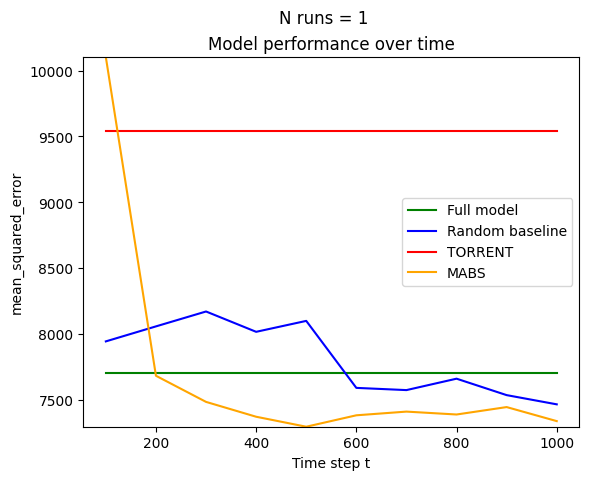

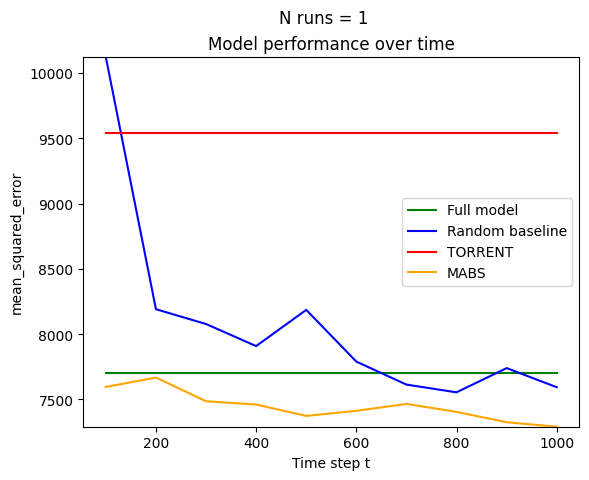

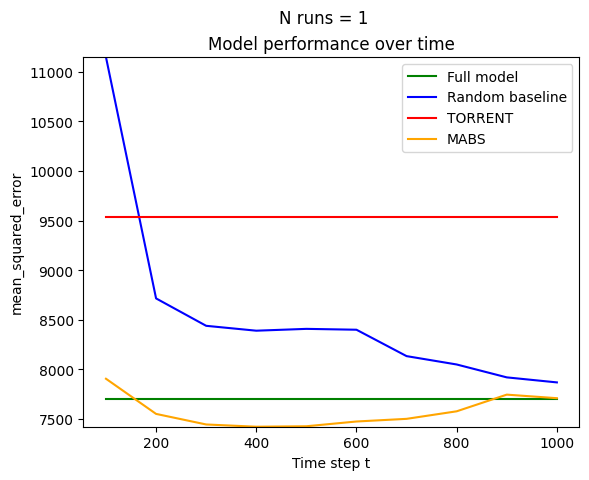

In [5]:
lazy_bandit_feature_search(features, tuple_size=2, n_runs=1, dataset=df_global_subset
                         , x=x, y=y, hidden_indices=hidden_indices, test_indices=test_indices
                         , val_indices=val_indices, T=T, batch_size=batch_size, test_freq=test_freq)

In [60]:
bandit_global.run_MABS()

In [17]:
specs_with_alos     = load_specs("25", "07", "2024", "13", "44", "01")
specs_with_alos['Terminal test scores']

{'Full model': 7593.880692315271,
 'Random baseline': 7108.007734682496,
 'TORRENT': 7211.385833250831,
 'MABS': 7400.3641306030895}

In [67]:
len({'a':1})

1

In [70]:
setty = {'a', 'b', 'c'}

', '.join(setty)

'c, a, b'

# -------------- DECOMISSIONED CODE --------------

### Testing the `reset_model_parameters()` method of the `MLP()`

In [ ]:
mlp_test = MLP(lr=0.01)

In [ ]:
mlp_test.state_dict()

OrderedDict([('layers.0.weight',
              tensor([[-1.7725e-01, -8.0801e-02, -1.2655e-01, -1.6921e-01,  1.6047e-01,
                       -2.4082e-01,  2.2508e-01,  1.9827e-02, -2.4130e-02,  2.2784e-01,
                       -1.0929e-01,  1.9830e-01],
                      [ 1.7183e-01,  7.4255e-02,  2.5018e-01,  9.7333e-02, -9.1000e-02,
                        1.3681e-02,  8.9149e-02, -1.7333e-01, -9.8761e-02, -1.3256e-01,
                       -1.0056e-01,  2.7845e-02],
                      [ 1.1330e-01,  2.3857e-01, -9.8897e-02, -1.5064e-02, -3.5706e-03,
                       -2.0592e-01, -5.0537e-02, -1.5435e-01,  2.4894e-01, -2.2260e-02,
                        2.7992e-01,  9.4989e-02],
                      [ 1.5034e-01,  2.6120e-01, -2.0115e-01, -9.1754e-03, -6.7325e-02,
                       -8.6602e-02,  2.6507e-01,  1.5840e-01, -2.8341e-02, -2.8405e-01,
                       -1.2883e-02,  1.0106e-01],
                      [ 1.2358e-01, -4.7308e-02, -2.2716e-01, -

In [ ]:
X_train = df_global_subset[df_global_subset['colour'] == 'train'][x].to_numpy()
y_train = df_global_subset[df_global_subset['colour'] == 'train'][y].to_numpy()

mlp_test.fit(X_train, y_train)

Batch 0. Epoch [1/5], Training loss: 8397.7310, lr: 0.01
Batch 0. Epoch [2/5], Training loss: 7521.1753, lr: 0.01
Batch 0. Epoch [3/5], Training loss: 7383.3465, lr: 0.01
Batch 0. Epoch [4/5], Training loss: 7221.3466, lr: 0.01
Batch 0. Epoch [5/5], Training loss: 7080.0426, lr: 0.01


In [ ]:
mlp_test.state_dict()

OrderedDict([('layers.0.weight',
              tensor([[-2.2852e-01, -1.3206e-01, -1.7782e-01, -2.2047e-01,  1.0921e-01,
                       -2.9208e-01,  1.7381e-01, -3.1436e-02, -7.5393e-02,  1.7658e-01,
                       -1.6056e-01,  1.4704e-01],
                      [ 1.9078e+00,  3.5054e-01, -1.4299e-02,  1.6420e+00, -1.3828e+00,
                        9.7621e-01,  8.6440e-01, -4.7966e-01, -4.4827e-01, -1.5285e+00,
                       -2.0869e+00, -9.1985e-01],
                      [ 1.7433e-01,  7.6337e-01,  7.3551e-01, -1.8736e+00, -2.9128e+00,
                       -2.0650e-01,  2.3673e-01, -7.5236e-01, -3.8648e-02, -6.9460e-01,
                        2.0633e+00, -5.2639e-01],
                      [-2.9483e-01, -8.3081e-01, -1.4584e+00,  1.7470e+00, -7.8197e-01,
                        8.2165e-01,  9.6394e-01,  3.0324e-01, -3.7562e-02, -1.5138e+00,
                       -1.0090e+00, -7.7624e-02],
                      [ 5.5912e-02, -1.1586e-01, -2.9150e-01, -

In [ ]:
mlp_test.reset_model_parameters()

In [ ]:
mlp_test.state_dict()

OrderedDict([('layers.0.weight',
              tensor([[-1.7725e-01, -8.0801e-02, -1.2655e-01, -1.6921e-01,  1.6047e-01,
                       -2.4082e-01,  2.2508e-01,  1.9827e-02, -2.4130e-02,  2.2784e-01,
                       -1.0929e-01,  1.9830e-01],
                      [ 1.7183e-01,  7.4255e-02,  2.5018e-01,  9.7333e-02, -9.1000e-02,
                        1.3681e-02,  8.9149e-02, -1.7333e-01, -9.8761e-02, -1.3256e-01,
                       -1.0056e-01,  2.7845e-02],
                      [ 1.1330e-01,  2.3857e-01, -9.8897e-02, -1.5064e-02, -3.5706e-03,
                       -2.0592e-01, -5.0537e-02, -1.5435e-01,  2.4894e-01, -2.2260e-02,
                        2.7992e-01,  9.4989e-02],
                      [ 1.5034e-01,  2.6120e-01, -2.0115e-01, -9.1754e-03, -6.7325e-02,
                       -8.6602e-02,  2.6507e-01,  1.5840e-01, -2.8341e-02, -2.8405e-01,
                       -1.2883e-02,  1.0106e-01],
                      [ 1.2358e-01, -4.7308e-02, -2.2716e-01, -

Now we try an `ND_bandit()`

Set column types and load data

In [ ]:
column_types = {
    "B01": "float64",
    "B02": "float64",
    "B03": "float64",
    "B04": "float64",
    "B05": "float64",
    "B06": "float64",
    "B07": "float64",
    "B08": "float64",
    "B8A": "float64",
    "B09": "float64",
    "B11": "float64",
    "B12": "float64",
    "lat_cos": "float64",
    "lat_sin": "float64",
    "lon_cos": "float64",
    "lon_sin": "float64",
    "gedi_num_days": "float64",
    "gedi_doy_cos": "float64",
    "gedi_doy_sin": "float64",
    "agbd_se": "float64",
    "elev_lowes": "float64",
    "pft_class": "category",
    "region_cla": "category",
    "rh98": "float64",
    "selected_a": "category",
    "sensitivit": "float64",
    "solar_elev": "float64",
    "urban_prop": "float64",
    "alos_hh": "float64",
    "alos_hv": "float64",
    "ch": "float64",
    "ch_std": "float64",
    "lc_cos": "float64",
    "lc_sin": "float64",
    "lc_prob": "float64",
    "dem": "float64",
    "agbd": "float64",
    "identity": "category"
}

df_satellite_band = pd.read_csv("df_satellite_band.csv", dtype=column_types)
# df_satellite_band = df_satellite_band.astype(column_types)

FileNotFoundError: [Errno 2] No such file or directory: 'df_satellite_band.csv'

In [4]:
frac_train              = 0.5
frac_test               = 0.48
frac_val                = 0.02

x                       = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12"]
y                       = 'agbd'
features                = {'pft_class':None, 'sensitivit':3, 'alos_hh':3}
T                       = 1000
batch_size              = 1
test_freq               = 50

lr                      = 0.01
num_epochs              = 10

bandit_satellite        = ND_bandit(df_satellite_band, x=x, y=y, features=features
                                    , frac_train=frac_train, frac_test=frac_test, frac_val=frac_val
                                    , T=T, batch_size=batch_size, test_freq=test_freq)

bandit_satellite.score  = mean_squared_error
bandit_satellite.model  = MLP(n_predictors=bandit_satellite.predictor_count, lr=lr, num_epochs=num_epochs)

In [8]:
bandit_satellite.train_indices      = bandit_satellite.hidden_indices[:]

In [9]:
X_train         = bandit_satellite.dataset[bandit_satellite.dataset.index.isin(bandit_satellite.train_indices)][bandit_satellite.x].to_numpy()
y_train         = bandit_satellite.dataset[bandit_satellite.dataset.index.isin(bandit_satellite.train_indices)][bandit_satellite.y].to_numpy()
X_test          = bandit_satellite.dataset[bandit_satellite.dataset.index.isin(bandit_satellite.test_indices)][bandit_satellite.x].to_numpy()
y_test          = bandit_satellite.dataset[bandit_satellite.dataset.index.isin(bandit_satellite.test_indices)][bandit_satellite.y].to_numpy()

Benchmarking run 1 for model full
Timestep 0. Epoch [1/5], Training loss: 1253.1975
Timestep 0. Epoch [2/5], Training loss: 1133.3530
Timestep 0. Epoch [3/5], Training loss: 1099.4086
Timestep 0. Epoch [4/5], Training loss: 1079.5215
Timestep 0. Epoch [5/5], Training loss: 1068.0936
Benchmarking run 1 for model rb
Timestep 0. Epoch [1/5], Training loss: 421.0737
Timestep 0. Epoch [2/5], Training loss: 389.3989
Timestep 0. Epoch [3/5], Training loss: 359.1838
Timestep 0. Epoch [4/5], Training loss: 331.0100
Timestep 0. Epoch [5/5], Training loss: 304.5076
Timestep 100. Epoch [1/5], Training loss: 1764.5145
Timestep 100. Epoch [2/5], Training loss: 1757.0933
Timestep 100. Epoch [3/5], Training loss: 1753.0432
Timestep 100. Epoch [4/5], Training loss: 1749.3774
Timestep 100. Epoch [5/5], Training loss: 1746.0242
Timestep 200. Epoch [1/5], Training loss: 1612.6649
Timestep 200. Epoch [2/5], Training loss: 1606.6049
Timestep 200. Epoch [3/5], Training loss: 1605.0086
Timestep 200. Epoch [4/

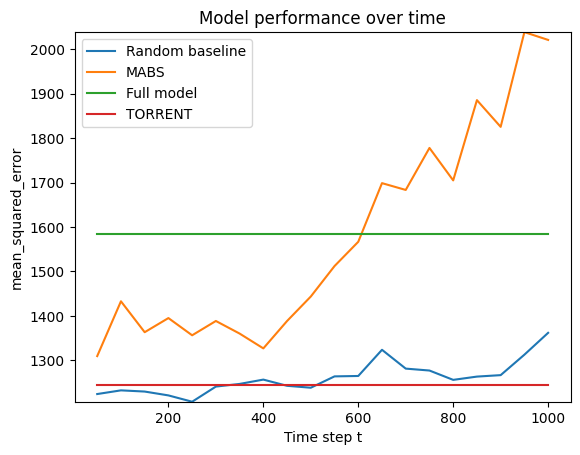

In [5]:
bandit_satellite.benchmark_MABS()

In [8]:
bandit_satellite.model.lr

0.001

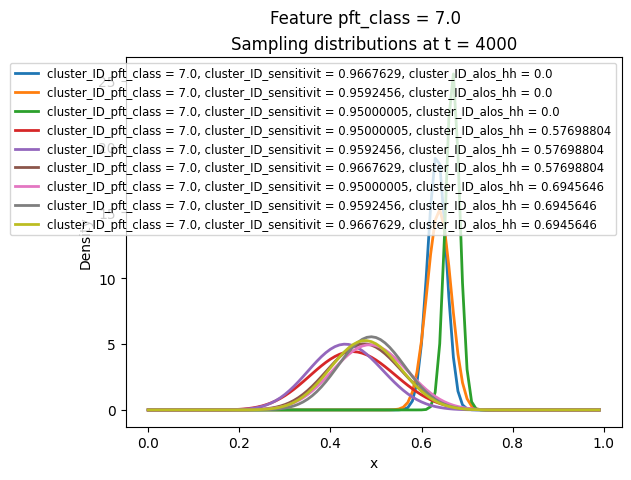

In [15]:
bandit_satellite.plot_beta_dist('pft_class', '7.0')

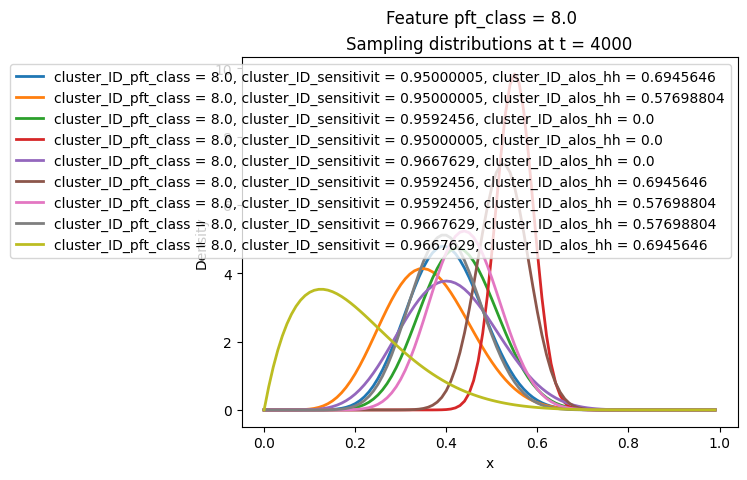

In [40]:
bandit_satellite.plot_beta_dist('pft_class', '8.0')

With MSE, all the error scores are very high! MSE = 3600 for the full model corresponds to errors around 63.

In [38]:
df_test         = df_satellite_band[df_satellite_band['identity'] == 'test']
df_train        = df_satellite_band[df_satellite_band['identity'] == 'train']
df_val          = df_satellite_band[df_satellite_band['identity'] == 'val']

mean_str        = "Mean of agbd in {} data is {}"

print(mean_str.format("train", round(np.mean(df_train['agbd']), 2)))
print(mean_str.format("test", round(np.mean(df_test['agbd']),2)))
print(mean_str.format("validation", round(np.mean(df_val['agbd']),2)))

Mean of agbd in train data is 25.47
Mean of agbd in test data is 44.89
Mean of agbd in validation data is 33.38


In [41]:
hidden_indices          = df_satellite_band[df_satellite_band['identity'] == 'train'].index.tolist()
val_indices             = df_satellite_band[df_satellite_band['identity'] == 'val'].index.tolist()
test_indices            = df_satellite_band[df_satellite_band['identity'] == 'test'].index.tolist()

x                       = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12"]
y                       = 'agbd'
features                = {'pft_class':None, 'sensitivit':3, 'alos_hh':3}
T                       = 4000
batch_size              = 1
test_freq               = 50

bandit_satellite        = ND_bandit(df_satellite_band, x=x, y=y, features=features
                                      , hidden_indices=hidden_indices, test_indices=test_indices, val_indices=val_indices
                                      , T=T, batch_size=batch_size, test_freq=test_freq)

bandit_satellite.score  = log_ratio

In [8]:
df_satellite_band.columns

Index(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09',
       'B11', 'B12', 'lat_cos', 'lat_sin', 'lon_cos', 'lon_sin',
       'gedi_num_days', 'gedi_doy_cos', 'gedi_doy_sin', 'agbd_se',
       'elev_lowes', 'pft_class', 'region_cla', 'rh98', 'selected_a',
       'sensitivit', 'solar_elev', 'urban_prop', 'alos_hh', 'alos_hv', 'ch',
       'ch_std', 'lc_cos', 'lc_sin', 'lc_prob', 'dem', 'agbd', 'identity'],
      dtype='object')

### 19/07 New Dataset

In [6]:
df_global = load_data()

with open(r"C:\Users\nial\OneDrive\ETH Zürich\Master Thesis\colouring.pkl", "rb") as colouring_file:

    colouring = pkl.load(colouring_file)

In [1]:
def decode_lat_lon(lat_cos, lat_sin, lon_cos, lon_sin):
    """
    Decode the sine/cosine values back into latitude and longitude.

    Args:
    - lat_cos (float): the cosine value of the latitude in [0, 1]
    - lat_sin (float): the sine value of the latitude in [0, 1]
    - lon_cos (float): the cosine value of the longitude in [0, 1]
    - lon_sin (float): the sine value of the longitude in [0, 1]

    Returns:
    - (lat, lon) (tuple): the decoded latitude and longitude
    """

    # Revert the values from [0,1] range back to [-1,1]
    lat_cos, lat_sin = lat_cos * 2 - 1, lat_sin * 2 - 1
    lon_cos, lon_sin = lon_cos * 2 - 1, lon_sin * 2 - 1

    # Calculate the latitude and longitude in radians
    lat_rad = np.arctan2(lat_sin, lat_cos)
    lon_rad = np.arctan2(lon_sin, lon_cos)

    # Convert from radians to degrees
    lat = lat_rad * 90 / np.pi
    lon = lon_rad * 180 / np.pi

    return lat, lon

In [11]:
df_global[['lat', 'lon']] = df_global.apply(lambda row: pd.Series(decode_lat_lon(row['lat_cos'], row['lat_sin'], row['lon_cos'], row['lon_sin'])), axis=1)

In [ ]:
# folium plot TTV split
subset = df_global.sample(n=1000, axis=0)

center_lat  = subset['lat'].mean()
center_lon  = subset['lon'].mean()
m           = folium.Map(location=[center_lat, center_lon], zoom_start=10)

colour_map = {
         'train': 'orange'
        ,'test' : 'blue'
        ,'val'  : 'green'
}

for _, row in subset.iterrows():
        
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            color=colour_map.get(row['colour'], 'gray'),
            fill=True
        ).add_to(m)

display(m)

### Custom TTV split

Running
Loaded data!
Computed proportions!
Validation colouring complete
Test colouring complete
Train colouring complete
Final proportions: train = 0.5055281906423734, test = 0.48129002852123837, val = 0.01318178083638825
Coloured tiles


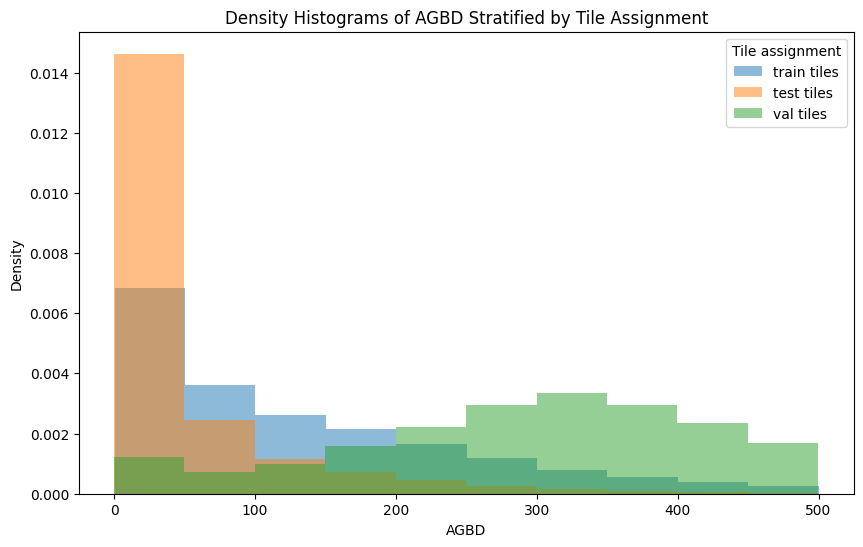

Train set quintiles of agbd:
[4.58755080e-01 2.53726840e+01 6.35054738e+01 1.29211116e+02
 2.22464782e+02 4.99988860e+02]
Test set quintiles of agbd:
[  0.          1.0742568   4.615956   26.157118   72.5544356 499.99203  ]
Validation set quintiles of agbd:
[  0.       185.626286 272.242908 333.81766  400.301322 499.81348 ]
Compared agbd distributions!
Computed proportions!
Validation colouring complete
Test colouring complete
Train colouring complete
Final proportions: train = 0.5015258275658355, test = 0.4757549912167105, val = 0.022719181217453904
Coloured tiles


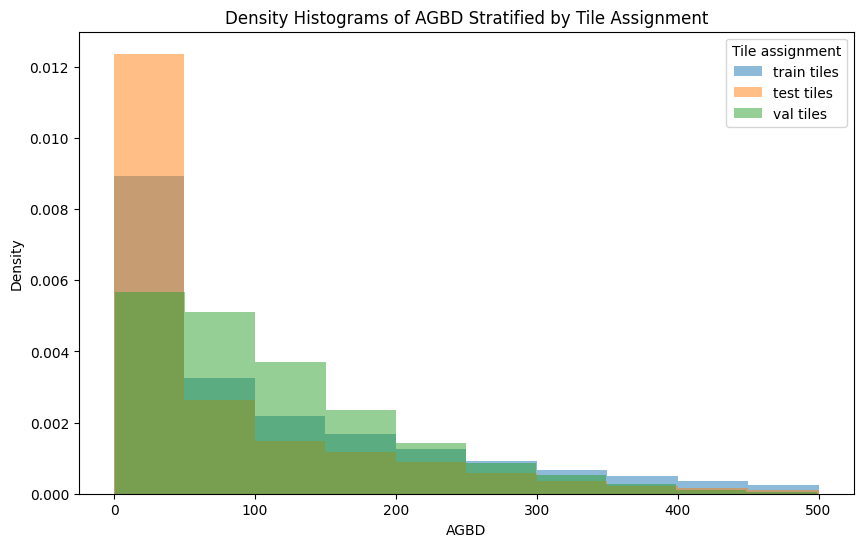

Train set quintiles of agbd:
[  0.          7.2251573  40.712296   96.07103   197.837446  499.98886  ]
Test set quintiles of agbd:
[  0.          2.088537   13.3525496  45.202198  131.284104  499.99203  ]
Validation set quintiles of agbd:
[  0.822904   38.0377648  70.593968  115.144002  180.533398  498.5991   ]
Compared agbd distributions!
Computed proportions!
Validation colouring complete
Test colouring complete
Train colouring complete
Final proportions: train = 0.5080888422881153, test = 0.47526985629834234, val = 0.016641301413542305
Coloured tiles


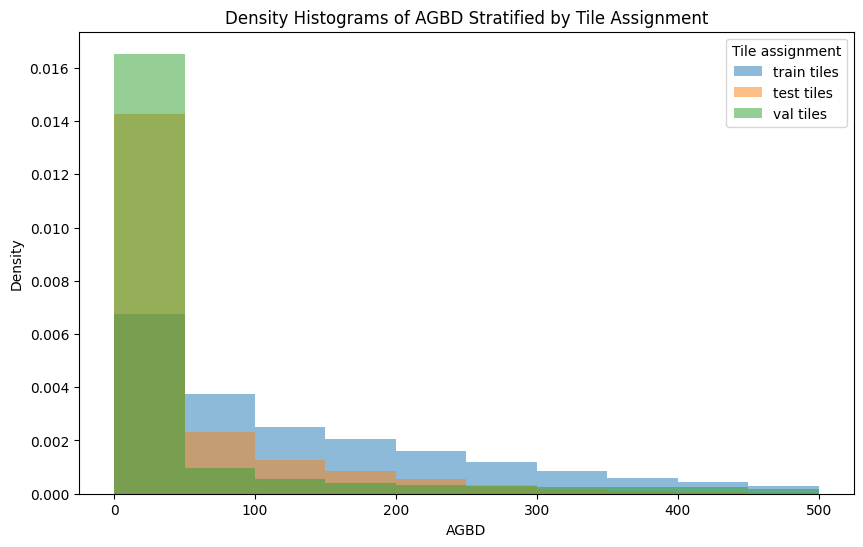

Train set quintiles of agbd:
[  0.         25.1311328  63.824012  128.711662  228.179534  499.98886  ]
Test set quintiles of agbd:
[  0.          1.0777532   5.6947904  28.795706   82.6598616 499.99203  ]
Validation set quintiles of agbd:
[  0.           1.09851996   1.91953646   5.26434738  34.1236296
 499.8912    ]
Compared agbd distributions!
Computed proportions!
Validation colouring complete
Test colouring complete
Train colouring complete
Final proportions: train = 0.5019278244437576, test = 0.4782442419571282, val = 0.019827933599114236
Coloured tiles


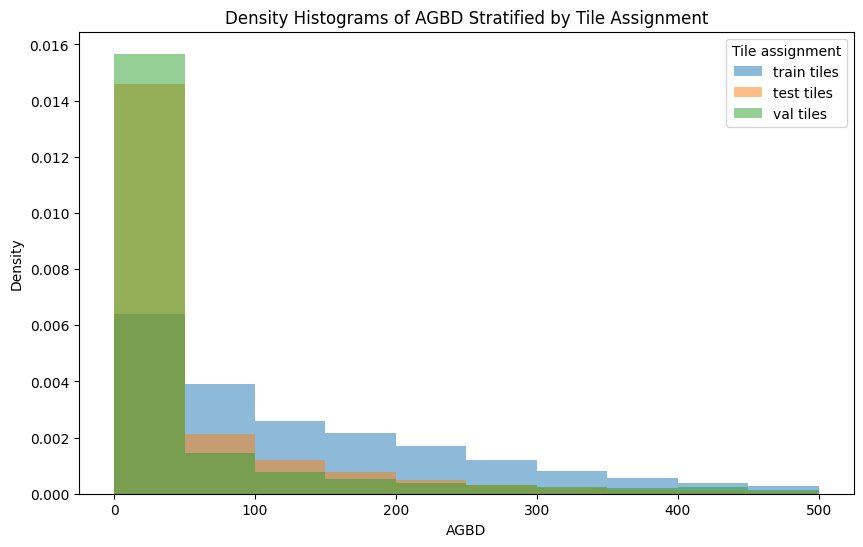

Train set quintiles of agbd:
[  0.        28.80305   67.122632 131.68915  226.400342 499.99203 ]
Test set quintiles of agbd:
[  0.          1.1160929   5.7562733  26.1590372  78.39134   499.92072  ]
Validation set quintiles of agbd:
[  0.           1.1660144    2.67565104  12.0461434   58.0091638
 499.8912    ]
Compared agbd distributions!
Computed proportions!
Validation colouring complete
Test colouring complete
Train colouring complete
Final proportions: train = 0.49595851313972267, test = 0.4841685609098627, val = 0.019872925950414518
Coloured tiles


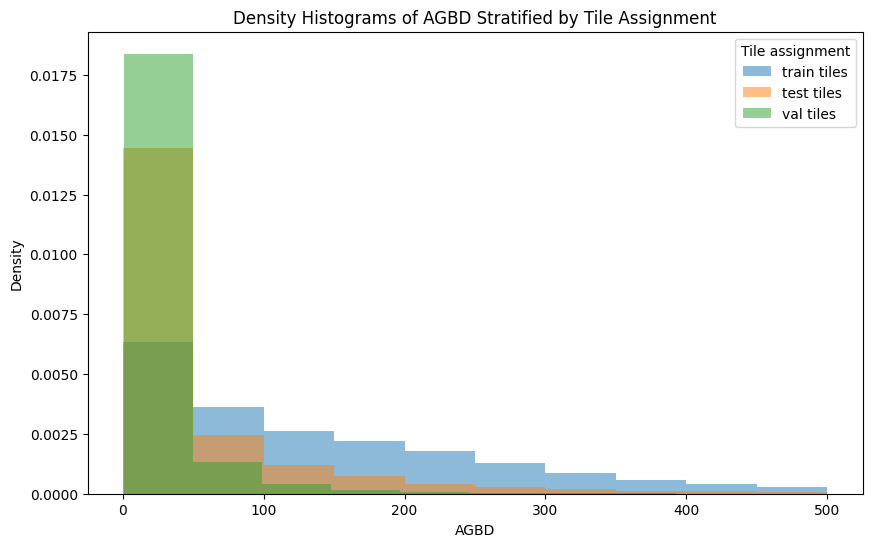

Train set quintiles of agbd:
[  0.        28.194492  70.05785  138.0246   232.49306  499.99203 ]
Test set quintiles of agbd:
[  0.          1.1160929   4.925063   27.4722908  75.664456  499.8912   ]
Validation set quintiles of agbd:
[  0.7879272   3.08123    11.1996214  16.9149836  31.2547874 490.28882  ]
Compared agbd distributions!
Invalid input. Must be one of 'Y' or 'N' (case sensitive)
Computed proportions!
Validation colouring complete
Test colouring complete
Train colouring complete
Final proportions: train = 0.5098220259077696, test = 0.4762362137567048, val = 0.01394176033552557
Coloured tiles


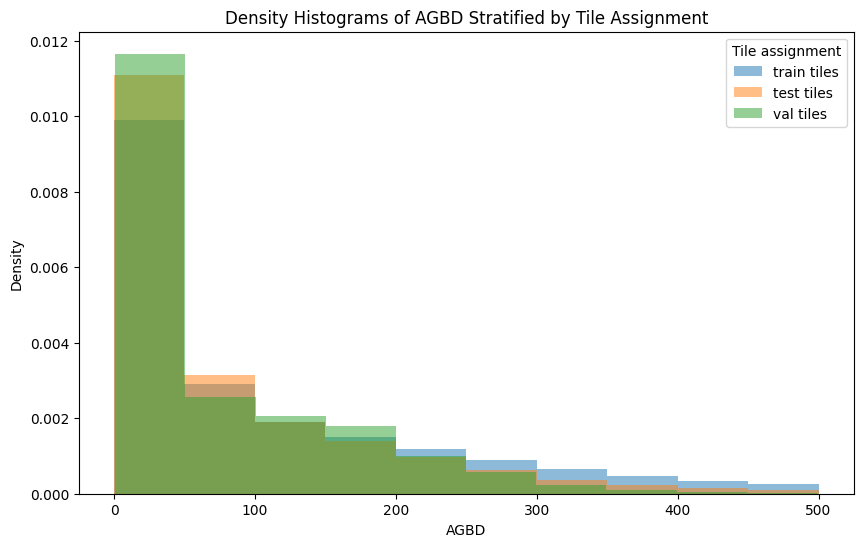

Train set quintiles of agbd:
[  0.          1.3763732  31.80726    82.571742  192.0165    499.98886  ]
Test set quintiles of agbd:
[  0.          4.6714244  22.732382   61.201394  146.237194  499.99203  ]
Validation set quintiles of agbd:
[  0.8347305   9.954384   21.6789844  56.2048566 144.919108  498.7916   ]
Compared agbd distributions!


<Figure size 640x480 with 0 Axes>

In [ ]:
os.chdir(r"C:\Users\nial\Documents\GitHub\Master-Thesis")
%run custom_ttv_split.py

### Benchmark against TORRENT method

Determine inliers with TORRENT

In [ ]:
x       = df_satellite_band[['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']]
y       = df_satellite_band[['agbd']]
a       = 4000 / len(df_satellite_band) # fraction of inliers

x       = x.to_numpy()
y       = y.to_numpy()

torrent = Torrent(a, fit_intercept=True)
torrent.fit(x,y)

Fit model to chosen inliers

In [ ]:
X       = x[torrent.inliers]
Y       = y[torrent.inliers]
model   = sm.OLS(Y, X).fit()

Predict on test set

In [ ]:
model.predict()

### Synthetic Beta Updates

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Score improved at timestep 0!
PFT class 2 sampled
Score worsened at timestep 1!
PFT class 1 sampled
Score worsened at timestep 2!
PFT class 2 sampled
Score improved at timestep 3!
PFT class 1 sampled
Score improved at timestep 4!
PFT class 2 sampled
Score worsened at timestep 5!
PFT class 2 sampled
Score improved at timestep 6!
PFT class 2 sampled
Score worsened at timestep 7!
PFT class 2 sampled
Score worsened at timestep 8!
PFT class 2 sampled
Score improved at timestep 9!
PFT class 1 sampled
Score improved at timestep 10!
PFT class 2 sampled
Score worsened at timestep 11!
PFT class 2 sampled
Score worsened at timestep 12!
PFT class 2 sampled
Score worsened at timestep 13!
PFT class 1 sampled
Score improved at timestep 14!
PFT class 1 sampled
Score worsened at timestep 15!
PFT class 2 sampled
Score worsened at timestep 16!
PFT class 2 sampled
Score improved at timestep 17!
PFT class 1 sampled
Score worsened at timestep 18!
PFT class 1 sampled
Score improved at timestep 19!
PFT class 

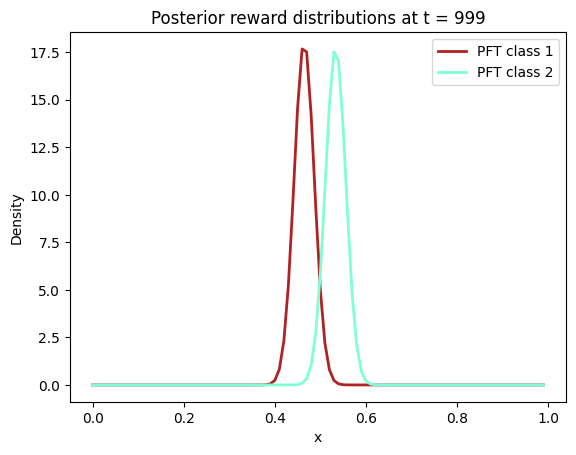

Score worsened at timestep 999!
PFT class 2 sampled


In [13]:
alphas                      = [1] * 2
betas                       = [1] * 2
labels                      = ['PFT class 1', 'PFT class 2']
colours                     = ['firebrick', 'aquamarine']
prev_score                  = 1
x                           = np.arange(100) / 100

for t in range(0,1000):
    
    if t == 999:
        plt.clf()
        plt.xlabel("x")
        plt.ylabel("Density")
        plt.legend(fontsize='small')
        plt.title(f"Posterior reward distributions at t = {t}")
    
        for i, _ in enumerate(labels):
            y                   = beta.pdf(x, a=alphas[i], b=betas[i])
            plt.plot(x,y,ls='-', linewidth=2, label=labels[i], color=colours[i])

        plt.legend()
        plt.show()
    
    pft_class               = np.random.choice([0,1])
    current_score           = np.random.uniform(0,1)
    
    if pft_class == 1:
        current_score       = current_score * 0.8

    if prev_score > current_score:

        print(f"Score improved at timestep {t}!")
        print(f"{labels[pft_class]} sampled")

        alphas[pft_class]   = alphas[pft_class] + 1
    
    else:

        print(f"Score worsened at timestep {t}!")
        print(f"{labels[pft_class]} sampled")

        betas[pft_class]    = betas[pft_class] + 1
        
    prev_score              = current_score



### Test the agent on `df_ghana`

Load `df_ghana`

In [ ]:
dtypes = {
     'pft_class': 'category'
    ,'leaf_off_f': 'category'
    ,'urban_prop': 'int64'
    ,'agbd': 'float64'
    ,'agbd_se': 'float64'
    ,'beam': 'category'
    ,'selected_a': 'category'
    ,'sensitivit': 'float64'
    ,'solar_elev': 'float64'
    ,'rh98': 'float64'
    ,'date': 'int64'
    ,'lat_cos': 'float64'
    ,'lat_sin': 'float64'
    ,'lon_cos': 'float64'
    ,'lon_sin': 'float64'
    ,'geometry': 'object'
}

df_ghana = pd.read_csv("df_ghana.csv", dtype=dtypes)

Benchmarking run 4


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Benchmarking run 5


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Benchmarking run 1


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Benchmarking run 2


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Benchmarking run 3


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Benchmarking run 4


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Benchmarking run 5


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


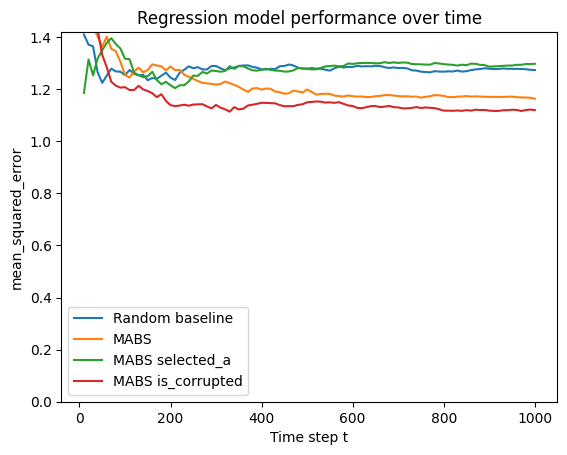

In [69]:
features_ghana  = {'selected_a':None}
x               = 'rh98'
y               = 'agbd'

crafty_boi = crafty_bandit(df_ghana, x=x\
                , y=y, features=features_ghana, T=1000, batch_size=1\
                , frac_train=0.8, frac_test=0.18, frac_val=0.02, test_freq=10, p_corrupt=0.1)

crafty_boi.benchmark_MABS(5)

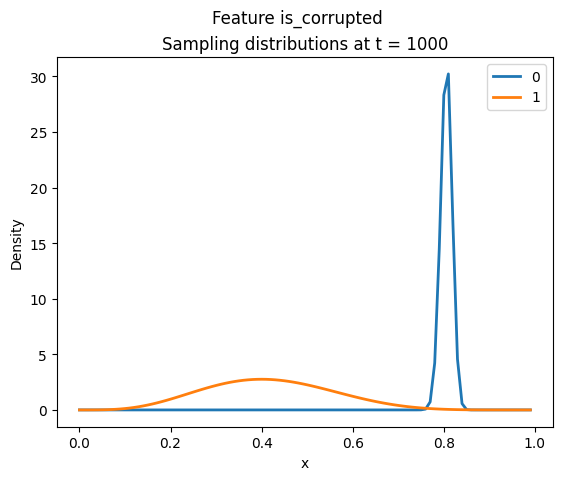

In [70]:
crafty_boi.plot_beta_dist('is_corrupted')

Summary: the agent performs as well as randomly selecting datapoints for the features tested. This is hardly surprising though. In simple linear regression, the model class considered is small.

In [ ]:
features = {'beam':None, 'selected_a':None}
bandit_boi = bandit(df_ghana, x='rh98', y='agbd', features=features, T=500, batch_size=1)
bandit_boi.benchmark_MABS(n_runs=10)

In [ ]:
features = {'beam':None, 'selected_a':None}
bandit_gal = bandit(df_ghana, x='rh98', y='agbd', features=features, T=500, batch_size=1)
bandit_gal.benchmark_MABS(n_runs=3)

In [ ]:
test_list = [x for x in range(51)]
test_list[10::10]

In [ ]:
features = {'beam':None, 'selected_a':None}
bandit_kid = bandit(df_ghana, x="rh98", y="agbd", features=features, T=50, batch_size=1)
bandit_kid.benchmark_MABS(n_runs=1)

Load previous bandit

In [ ]:
with open('bandit_boi.pkl', 'rb') as file:
    bandit_boi = pkl.load(file)

### Test the agent on `Appliances Energy Prediction`

We will test the agent on another dataset, `Appliances Energy Production`. The dataset consists of 19,000 measurements of household energy consumption, temperature and humidity conditions, co-located with meteorological variables. Our objective is to predict energy usage given the environmental variables.


In [ ]:
def get_df_energy():
    """
    Quick function to load & preprocess the appliances energy data.
    """
    # fetch dataset 
    appliances_energy_prediction = fetch_ucirepo(id=374)
    df_energy = appliances_energy_prediction.data['original']

    df_energy['date']       = pd.to_datetime(df_energy['date'], format='%Y-%m-%d%H:%M:%S')
    df_energy['month']      = df_energy['date'].dt.month
    # df_energy['month']      = df_energy['month'].astype('category')
    df_energy['lights']     = df_energy['lights'].astype('category')

    # difference between outside and inside temperature is a relevant variable

    df_energy['T_inside']   = df_energy.apply(lambda row: np.mean([row['T1'], row['T2'], row['T3'], row['T4'],\
                                                                   row['T5'], row['T7'], row['T8'], row['T9']])\
                                                                   , axis=1)

    df_energy['heating']    = df_energy['T_inside'] - df_energy['T6']

    df_energy['humid_in']   = df_energy.apply(lambda row: np.mean([row['RH_1'], row['RH_2'], row['RH_3'], row['RH_4'],\
                                                                   row['RH_5'], row['RH_7'], row['RH_8'], row['RH_9']])\
                                                                   , axis=1)

    df_energy['humid_diff'] = df_energy['humid_in'] - df_energy['RH_6']

    return df_energy

In [ ]:
df_energy = get_df_energy()
df_energy.columns

Column `Appliances` is the response variable (energy use in Wh). `TX` and `RHX` are temperature and relative humidity metrics for room `X`, respectively, while `lights` is the energy use of light fixtures in the house (Wh). The rest of the variables are meteorological measurements from a nearby weather station. A priori, I would expect that the `lights` variable is relevant for determining clusters, while `T_out` is a relevant predictor. 

In [ ]:
features_energy = {'month':None}

bandit_energy   = bandit(df_energy, x=['heating', 'lights', 'Press_mm_hg', 'humid_diff', 'Windspeed', 'Visibility', 'Tdewpoint']\
                        , y='Appliances', features=features_energy, T=1000, frac_train=0.8, frac_val=0.02, frac_test=0.18)

We model the appliances energy consumption using temperatures from most rooms and the relative humidity in the bathroom.

In [ ]:
bandit_energy.benchmark_MABS(n_runs=10)

Perhaps picking observations based on the month in which they are made is not a useful strategy...

In [ ]:
features_energy = {'lights':None}

bandit_energy   = bandit(df_energy, x=['heating', 'humid_diff']\
                        , y='Appliances', features=features_energy, T=1000, frac_train=0.8, frac_val=0.02, frac_test=0.18)

In [ ]:
bandit_energy.benchmark_MABS(n_runs=10)

What is R2 with model for heating and lights, no selection?

In [ ]:
appliances_energy_prediction = fetch_ucirepo(id=374)
df_orig = appliances_energy_prediction.data['original']

In [ ]:
linear_model = LinearRegression()

In [ ]:
linear_model.fit(df_orig[[col for col in df_orig.columns if col not in ['date', 'Appliances']]], df_orig['Appliances'])

In [ ]:
y_pred = linear_model.predict(df_orig[[col for col in df_orig.columns if col not in ['date', 'Appliances']]])
r2      = r2_score(df_orig['Appliances'], y_pred)
var_exp = explained_variance_score(df_orig['Appliances'], y_pred)
r2, var_exp

With all predictors and whole dataset, $R^2 = 0.16$, suggesting that this prediction task may be too difficult for separating good and bad models :/

### Data Loading

Manually set `dtypes`

In [ ]:
dtypes = {
     'pft_class': 'category'
    ,'region_cla': 'category'
    ,'leaf_off_f': 'category'
    ,'urban_prop': 'int64'
    ,'agbd': 'float64'
    ,'agbd_se': 'float64'
    ,'beam': 'category'
    ,'elev_lowes': 'float64'
    ,'lat_lowest': 'float64'
    ,'lon_lowest': 'float64'
    ,'selected_a': 'category'
    ,'shot_numbe': 'int64'
    ,'sensitivit': 'float64'
    ,'solar_elev': 'float64'
    ,'rh98': 'float64'
    ,'pattern': 'object'
    ,'doy_sin': 'float64'
    ,'doy_cos': 'float64'
    ,'date': 'int64'
    ,'lat_cos': 'float64'
    ,'lat_sin': 'float64'
    ,'lon_cos': 'float64'
    ,'lon_sin': 'float64'
    ,'pft_class_group': 'category'
    ,'geometry': 'object'
}

df_ghana_subsample = pd.read_csv('df_ghana_subsample.csv', dtype=dtypes)

Save `df_ghana`

In [ ]:
df_ghana = gpd.read_file("GEDI_Ghana.geojson"
                         , driver = 'GeoJSON'
                         , engine='pyogrio')

df_ghana = df_ghana[df_ghana['pft_class'] == 2]

cols_to_keep = ['pft_class', 'leaf_off_f','urban_prop','agbd','agbd_se', 'beam', 'selected_a', 'sensitivit'\
                     , 'solar_elev', 'rh98', 'date', 'lat_cos','lat_sin','lon_cos','lon_sin', 'geometry']

df_ghana = df_ghana[cols_to_keep]

df_ghana.to_csv("df_ghana.csv", index=False)

df_ghana.head(5)

### Test the agent on `Bike Sharing Data`

We have 17379 observations corresponding to hourly measurements of weather and a variable `cnt` indicating the number of bikes rented.

In [ ]:
def classify_day(row):
    """
    Simplify classification of DOTW
    """
    if row['holiday'] == 1: return 'holiday'
    elif row['weekday'] in [0,6]: return 'weekend'
    else: return 'work day'

In [ ]:
def classify_hr(row):
    """
    Simplify classification of hr
    """
    if row['hr'] in [8,16,17,18,19]: return 'rush hour'
    elif row['hr'] in [7, 9, 10, 11, 12, 13, 14, 15, 20]: return 'day'
    else: return 'night'

In [ ]:
def get_df_bike():
    """
    Wrapper to fetch and preprocess the bike sharing data.
    """
    bike                = fetch_ucirepo(id=275)
    df_bike             = bike.data['original']

    # simplify classificaitons
    df_bike['day_type'] = df_bike.apply(lambda row: classify_day(row), axis=1)
    df_bike['hr_type']  = df_bike.apply(lambda row: classify_hr(row), axis=1)

    # cat cols
    cat_cols            = ['day_type', 'hr_type', 'season', 'weathersit']
    df_bike[cat_cols]   = df_bike[cat_cols].astype('category')
    
    # drop redundant columns
    df_bike.drop(columns=['casual', 'registered', 'temp', 'holiday', 'weekday', 'workingday', 'hr', 'mnth', 'dteday', 'instant'], inplace=True)

    return df_bike, cat_cols

In [ ]:
average_cnt_by_hr = df_bike.groupby('hr')['cnt'].mean()

plt.figure(figsize=(10, 6))
plt.plot(average_cnt_by_hr.index, average_cnt_by_hr.values, marker='o', linestyle='-', color='b')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Count')
plt.title('Average Count by Hour of the Day')
plt.grid(True)
plt.xticks(range(24))  # Assuming hr is in 24-hour format
plt.show()

In [ ]:
df_encoded.head()

In [ ]:
df_bike.head()

In [ ]:
df_bike, cat_cols = get_df_bike()
df_encoded        = pd.get_dummies(df_bike, columns=['season', 'yr', 'weathersit'], drop_first=True)

bike_features = {'day_type': None, 'hr_type': None}
x             = [col for col in df_encoded.columns if col not in ['cnt', 'day_type', 'hr_type']]


# bandit_bike = bandit(df_encoded, x=x\
#                , y='cnt', features= bike_features, T=1000, batch_size=1\
#                , frac_train=0.8, frac_test=0.18, frac_val=0.02, test_freq=10)

crafty_bandit_bike = crafty_bandit(df_encoded, x=x\
                , y='cnt', features= bike_features, T=1000, batch_size=1\
                , frac_train=0.8, frac_test=0.18, frac_val=0.02, test_freq=10, p_corrupt=0.1)

In [ ]:
crafty_bandit_bike.features

In [ ]:
crafty_bandit_bike.benchmark_MABS(n_runs=3)

In [ ]:
crafty_bandit_bike.plot_beta_dist('is_corrupted')

In [ ]:
bandit_bike.benchmark_MABS(n_runs=10)

In [ ]:
len(y_hat)

In [ ]:
y       = np.array([3, 3])
y_hat   = np.array([6, 7])

mean_absolute_percentage_error(y, y_hat)

In [ ]:
bandit_mse.reset()
bandit_mse.benchmark_MABS(n_runs=10)

In [ ]:
bandit_UTH.reset()
bandit_UTH.benchmark_MABS(n_runs=10)

In [ ]:
len(bandit_UTH.test_scores)

In [ ]:
bandit_UTH.plot_beta_dist('day_type')

In [ ]:
# LASSO
bike_bandit.benchmark_MABS(n_runs=10)

In [ ]:
# RIDGE

bike_bandit.benchmark_MABS(n_runs=10)

### Testing decorators

In [39]:
def decorator(lazy):

    def actual_decorator(cls):
        
        parent = Test_1 if lazy else Test_2

        # Define a new class that inherits from the chosen parent class
        class WrappedClass(parent, cls):
            pass
        
        return WrappedClass
    return actual_decorator

In [34]:
class Test_1():
    
    def print_message(self):
        print("Reporting from Test_1() class")

class Test_2():
    
    def print_message(self):
        print("Reporting from Test_2() class")

In [44]:
@decorator(lazy=False)
class Test_3():

    pass

In [45]:
t3 = Test_3()
t3.print_message()

Reporting from Test_2() class


### Making Satellite Band DataFrame

Load features and labels

In [ ]:
suffix          = "_2020-vghana.csv"

test_features   = pd.read_csv("test_features" + suffix)
test_labels     = pd.read_csv("test_labels" + suffix)
train_features  = pd.read_csv("train_features" + suffix)
train_labels    = pd.read_csv("train_labels" + suffix)
val_features    = pd.read_csv("val_features" + suffix)
val_labels      = pd.read_csv("val_labels" + suffix)

Merge into one dataset

In [6]:
test_features['agbd']           = test_labels['agbd']
train_features['agbd']          = train_labels['agbd']
val_features['agbd']            = val_labels['agbd']

test_features['identity']       = 'test'
train_features['identity']      = 'train'
val_features['identity']        = 'val'

df_satellite_band               = pd.concat([train_features, val_features, test_features], ignore_index=True)
df_satellite_band.to_csv("df_satellite_band.csv", index=False)

NameError: name 'test_labels' is not defined